In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
base_skin_dir = 'data'
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Concatenate, concatenate, Input
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from keras.layers. normalization import BatchNormalization
import keras
from keras.utils.np_utils import to_categorical

from PIL import Image

batch_size = 128
num_classes = 10
epochs = 5

Using TensorFlow backend.


In [2]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [3]:
tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
tile_df = tile_df.sample(10000)
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df['localization'] = pd.Categorical(tile_df['localization']).codes
#tile_df.sample(500)



In [4]:
tile_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
7093,HAM_0002581,ISIC_0026544,nv,histo,40.0,male,2,data/HAM10000_images_part_1/ISIC_0026544.jpg,Melanocytic nevi,4
1772,HAM_0001272,ISIC_0029265,mel,histo,85.0,male,14,data/HAM10000_images_part_1/ISIC_0029265.jpg,dermatofibroma,6
7410,HAM_0007005,ISIC_0032568,nv,histo,40.0,female,1,data/HAM10000_images_part_2/ISIC_0032568.jpg,Melanocytic nevi,4
5075,HAM_0003121,ISIC_0024347,nv,follow_up,25.0,female,14,data/HAM10000_images_part_1/ISIC_0024347.jpg,Melanocytic nevi,4
5248,HAM_0004107,ISIC_0029769,nv,follow_up,40.0,female,12,data/HAM10000_images_part_2/ISIC_0029769.jpg,Melanocytic nevi,4


In [5]:
tile_df.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,path,cell_type
count,1000,1000,1000,1000,1000,1000,1000
unique,968,1000,7,4,3,1000,7
top,HAM_0003130,ISIC_0027139,nv,histo,male,data/HAM10000_images_part_1/ISIC_0026608.jpg,Melanocytic nevi
freq,2,1,665,529,524,1,665


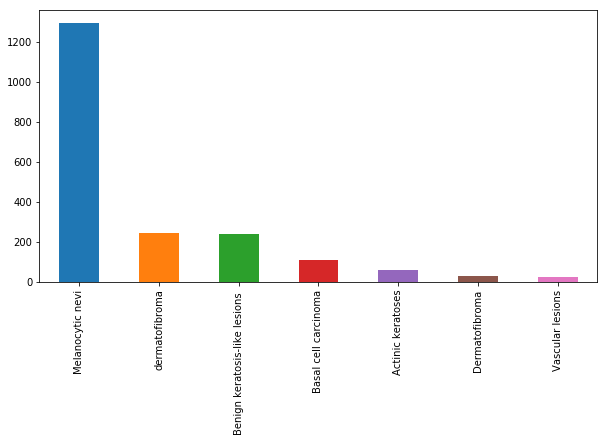

In [5]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)


In [4]:
# load in all of the images
from skimage.io import imread
#tile_df['image'] = tile_df['path'].map(imread)
#tile_df['image'] = np.array(tile_df['image']) #np.array(img)

tile_df['image'] = tile_df['path'].map(lambda x: np.asarray(Image.open(x).resize((120,90))))       

In [5]:
# see the image size distribution
tile_df['image'].map(lambda x: x.shape).value_counts()

(90, 120, 3)    5000
Name: image, dtype: int64

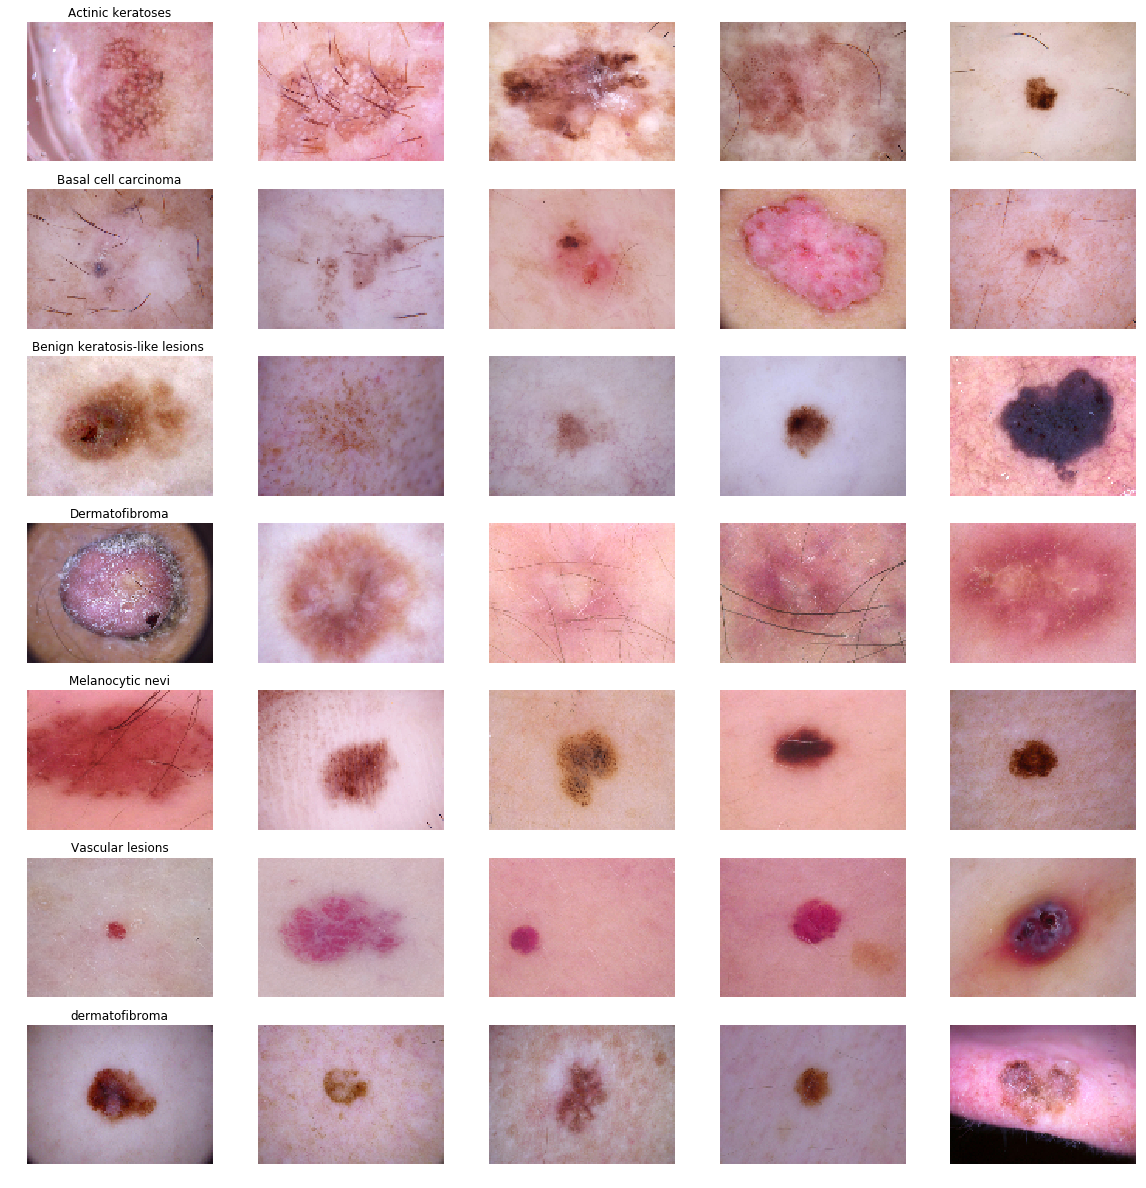

In [6]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [5]:
y = tile_df.cell_type_idx

from sklearn.model_selection import train_test_split
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(tile_df, y, test_size=0.25, random_state = 42)

x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [11]:

bnd_input = Input(shape=(90, 120,  3))
layer1 = Conv2D(32, kernel_size = (3, 3), activation='relu')(bnd_input)
layer2 = MaxPooling2D(pool_size=(2, 2), )(layer1)
conv2 = Conv2D(64, kernel_size = (3, 3), activation='relu')(layer2)
pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
layer3 = Flatten() (pool2)
layer3 = Dense(24, activation='relu') (layer3)


aux_in = Input(shape=(x_train_o['localization'].ndim,))
aux_features = Dense(24, activation='relu')(aux_in)

merged = concatenate([layer3, aux_features], axis=-1)
out = Dense(7, activation='softmax')(merged)
#out = Dense(7, activation='softmax')(out)
model = Model([bnd_input, aux_in], out)


#model2.add(Dense(1, input_shape=(x_train_o['localization'].size,), activation='relu'))

#type(model2)

#concat = Concatenate(axis=0)
#merged = concat([model1, model2])
#merged.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
model.summary()
#model1.add(Dropout(0.3))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 90, 120, 3)   0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 88, 118, 32)  896         input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 44, 59, 32)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 42, 57, 64)   18496       max_pooling2d_5[0][0]            
__________________________________________________________________________________________________
max_poolin

In [8]:

bnd_input = Input(shape=(90, 120,  3))
layer1 = Conv2D(32, kernel_size = (3, 3), activation='relu')(bnd_input)
layer2 = MaxPooling2D(pool_size=(2, 2), )(layer1)
conv2 = Conv2D(64, kernel_size = (3, 3), activation='relu')(layer2)
pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
layer3 = Flatten() (pool2)
layer3 = Dense(24, activation='relu') (layer3)
layer4 = Dropout(0.3)(layer3)

aux_in = Input(shape=(x_train_o['localization'].ndim,))
aux_features = Dense(24, activation='relu')(aux_in)

#merged = concatenate([layer3, aux_features], axis=-1)
out = Dense(7, activation='softmax')(layer4)
#out = Dense(7, activation='softmax')(out)
model = Model([bnd_input], out)


#model2.add(Dense(1, input_shape=(x_train_o['localization'].size,), activation='relu'))

#type(model2)

#concat = Concatenate(axis=0)
#merged = concat([model1, model2])
#merged.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
model.summary()
#model1.add(Dropout(0.3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 90, 120, 3)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 88, 118, 32)       896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 44, 59, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 42, 57, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 21, 28, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 37632)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                903192    
__________

In [57]:
first_input = Input(shape=(x_train_o['localization'].size, ))


top_aux_model = Sequential()
top_aux_model.add(Dense(x_train_o['localization'].size, input_shape=(x_train_o['localization'].size,), name='aux_input'))
top_aux_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
aux_input (Dense)            (None, 750)               563250    
Total params: 563,250
Trainable params: 563,250
Non-trainable params: 0
_________________________________________________________________


In [75]:
merge_one = Concatenate([model1, top_aux_model])
model = Model(inputs=[model1, top_aux_model], outputs=merge_one)

ValueError: Input tensors to a Model must come from `keras.layers.Input`. Received: <keras.engine.sequential.Sequential object at 0x7f6dc804dd68> (missing previous layer metadata).

In [52]:
#merged = concatenate([model1, top_aux_model])

#merged = Concatenate([model1, top_aux_model]) # Merge data must same row column
#type(merged)
#output = Dense(7, activation='softmax')(merged)
#model = Model(inputs=[model1, top_aux_model], outputs=output)
#model.summary()


merged = Concatenate([model1, top_aux_model])

#final_model = Model(inputs=[model1, top_aux_model], outputs=output)
#final_model.add(merged)
#final_model.add(Dense(7, activation = 'softmax'))
#final_model.summary()

final_model = Sequential()
final_model.add(merged)
final_model.add(Dropout(0.3))


In [53]:
final_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [54]:
final_model.summary()

ValueError: This model has not yet been built. Build the model first by calling build() or calling fit() with some data. Or specify input_shape or batch_input_shape in the first layer for automatic build. 

In [54]:
x_train_o['localization'].ndim

1

In [12]:
#final_model.compile(loss=keras.losses.categorical_crossentropy,
#              optimizer=keras.optimizers.Adadelta(),
#              metrics=['accuracy'])

batch_size = 150 # Todo: experiment with this variable more
epochs = 3
#x_test_o['image'].tolist()
history = model.fit([x_train, x_train_o['localization']] , y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([x_test, x_test_o['localization']], y_test))

score = model.evaluate([x_test, x_test_o['localization']], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#print('Summary:', final_model.summary())

Train on 7500 samples, validate on 2500 samples
Epoch 1/3
7500/7500 [==============================] - 65s 9ms/step - loss: 1.5108 - acc: 0.5852 - val_loss: 1.1151 - val_acc: 0.6144
Epoch 2/3
7500/7500 [==============================] - 65s 9ms/step - loss: 0.9512 - acc: 0.6676 - val_loss: 0.9370 - val_acc: 0.6664
Epoch 3/3
7500/7500 [==============================] - 66s 9ms/step - loss: 0.8548 - acc: 0.6861 - val_loss: 0.8349 - val_acc: 0.6848
Test loss: 0.8349287410736084
Test accuracy: 0.6848


In [10]:
#final_model.compile(loss=keras.losses.categorical_crossentropy,
#              optimizer=keras.optimizers.Adadelta(),
#              metrics=['accuracy'])

batch_size = 150 # Todo: experiment with this variable more
epochs = 3
#x_test_o['image'].tolist()
history = model.fit([x_train] , y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([x_test], y_test))

score = model.evaluate([x_test], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#print('Summary:', final_model.summary())

Train on 7500 samples, validate on 2500 samples
Epoch 1/3
7500/7500 [==============================] - 66s 9ms/step - loss: 1.2736 - acc: 0.5696 - val_loss: 0.9821 - val_acc: 0.6680
Epoch 2/3
7500/7500 [==============================] - 65s 9ms/step - loss: 1.0458 - acc: 0.6315 - val_loss: 0.8833 - val_acc: 0.6676
Epoch 3/3
7500/7500 [==============================] - 65s 9ms/step - loss: 0.9849 - acc: 0.6461 - val_loss: 0.8561 - val_acc: 0.6628
Test loss: 0.8560888591766358
Test accuracy: 0.6628


/home/efs/anaconda3/envs/csc8635_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


TypeError: Invalid dimensions for image data

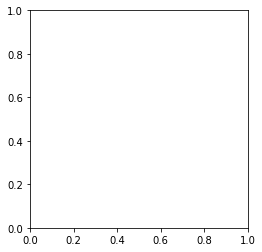

In [34]:
import matplotlib.pyplot as plt
def visualize_incorrect_labels(x_data, y_real, y_predicted):
    # INPUTS
    # x_data      - images
    # y_data      - ground truth labels
    # y_predicted - predicted label
    count = 0
    figure = plt.figure()
    incorrect_label_indices = (y_real != y_predicted)
    y_real = y_real[incorrect_label_indices]
    y_predicted = y_predicted[incorrect_label_indices]
    x_data = x_data[incorrect_label_indices, :, :, :]

    maximum_square = np.ceil(np.sqrt(x_data.shape[0]))

    for i in range(x_data.shape[0]):
        count += 1
        figure.add_subplot(maximum_square, maximum_square, count)
        plt.imshow(x_data[i, :, :, :])
        plt.axis('off')
        plt.title("Predicted: " + str(int(y_predicted[i])) + ", Real: " + str(int(y_real[i])), fontsize=10)

    plt.show()

prediction1 = model.predict(x_test)
prediction1 = np.round(prediction1)

visualize_incorrect_labels(x_test, y_test, np.asarray(prediction1).ravel())

In [33]:
np.asarray(prediction1).ravel()

array([2.4699185e-03, 4.1043689e-03, 1.1727691e-01, ..., 9.5515299e-01,
       3.7329879e-05, 4.4051912e-02], dtype=float32)

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

model.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800)

In [ ]:
train_batch_size = 64
def random_batch():
    # Number of images in the training-set.
    num_images = len(images_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch